In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.data import AUTOTUNE

2023-02-28 00:10:23.238446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model = keras.models.load_model('neural_net')

img_height = 256
img_width = 256
image_dir = "images"
batch_size = 32

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    labels="inferred",
    class_names=["Austria","Australia"],
    subset="both",
    seed = 0,
    batch_size = batch_size,
    crop_to_aspect_ratio=True,
    image_size=(img_height, img_width))

def standardize_image(image, label):
    mean = tf.reduce_mean(image)
    std = tf.math.reduce_std(image)
    standardized_image = tf.map_fn(lambda x: (x - mean)/std, image)
    return (standardized_image, label)

train_ds =  train_ds.map(standardize_image)
val_ds = val_ds.map(standardize_image)


train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)


Found 25064 files belonging to 2 classes.
Using 20052 files for training.
Using 5012 files for validation.


In [3]:
def adversarial_transformation(model, eps):

    def func(image, label):

        with tf.GradientTape() as g:
            g.watch(image)
            predicted_label = model(image)
            loss = losses.BinaryCrossentropy()(label, predicted_label)

            gradient = g.gradient(target = loss, sources = image)
            signed_gradient = tf.sign(gradient)
            adv_image = image + signed_gradient * eps

        return adv_image, label
    
    return func

In [4]:
eps_array = [0,1e-3,1e-2,1e-1,1e-0]


for eps in eps_array:
    print(f"{eps=}")
    if eps == 0:
        loss, accuracy = model.evaluate(val_ds)
    else:
        adv_ds = val_ds.map(adversarial_transformation(model, eps))
        loss, accuracy = model.evaluate(adv_ds)
        
        

eps=0
157/157 [==============================] - 456s 3s/step - loss: 0.0911 - accuracy: 0.9637
eps=0.0001
157/157 [==============================] - 450s 3s/step - loss: 0.0962 - accuracy: 0.9621
eps=0.001
157/157 [==============================] - 446s 3s/step - loss: 0.1504 - accuracy: 0.9413
eps=0.01
157/157 [==============================] - 444s 3s/step - loss: 1.3450 - accuracy: 0.6453
eps=0.1
157/157 [==============================] - 452s 3s/step - loss: 9.4306 - accuracy: 0.2155
eps=1.0
157/157 [==============================] - 446s 3s/step - loss: 4.6261 - accuracy: 0.3164


1/1 [==============================] - 0s 259ms/step
0.99996006 Australia
0.024388326 Austria
0.020617152 Austria
0.9999997 Australia
0.0011453863 Austria
0.99967784 Australia
0.12847742 Austria
0.9999997 Australia
0.03663305 Austria
0.00068378774 Austria


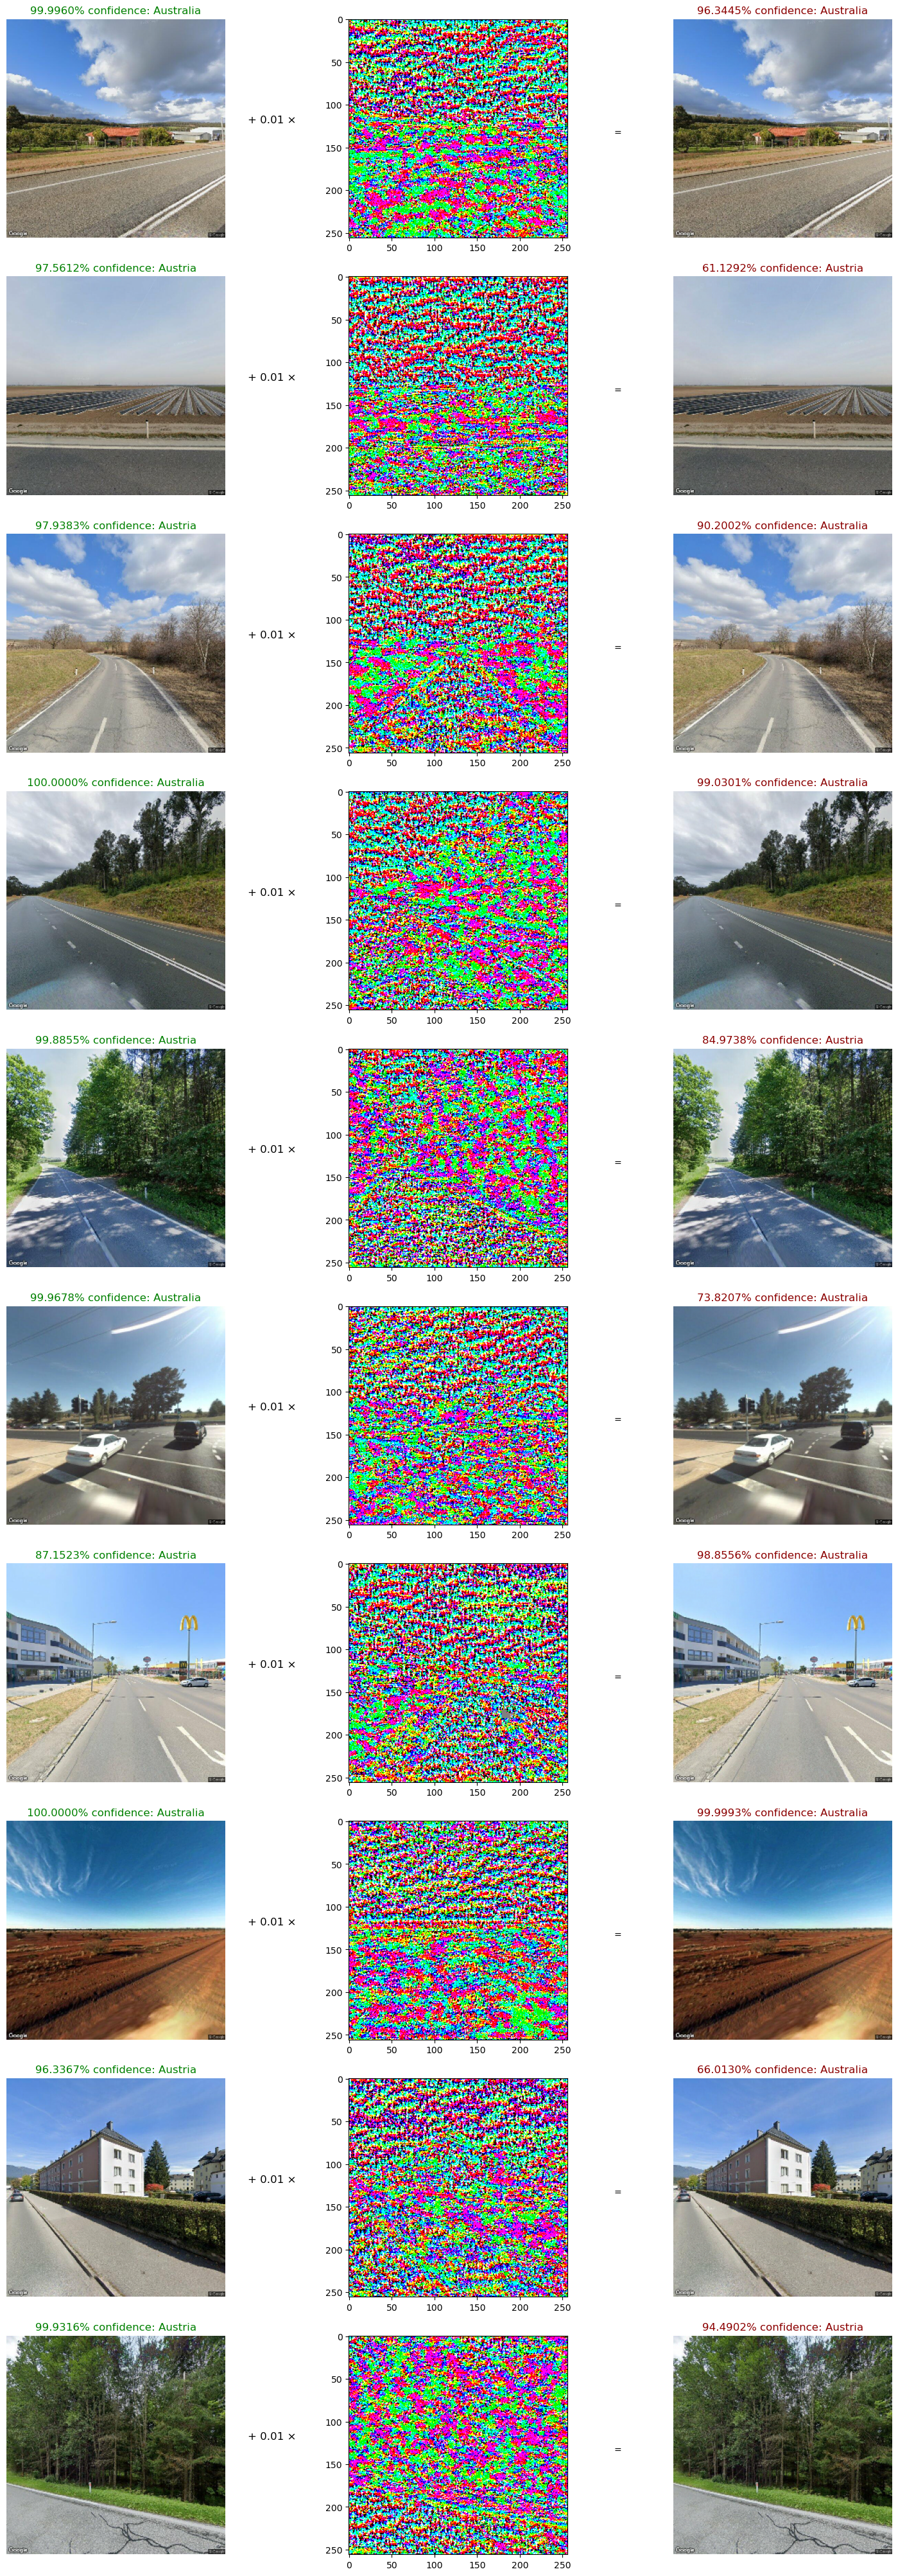

In [7]:
eps = 0.01

num_images = 10
fig = plt.figure(figsize = (15, num_images*4), constrained_layout=True)
subfigs = fig.subfigures(nrows=num_images, ncols=1)

class_labels = ["Austria", "Australia"]


def plot_standardized_image(image):
    image = image.numpy()
    image_min = np.min(image)
    image_max = np.max(image)
    if image_max - image_min > 0:
        image = (image - (image_min + image_max)/2)/(image_max - image_min) + 1/2
    plt.imshow(image)

for images, labels in val_ds.take(1):
    predictions = model.predict(images).reshape((32,))
    adv_images, _ = adversarial_transformation(model, eps)(images, labels)
    adv_predictions = model.predict(adv_images)
    i = 0
    for image, prediction, adv_image, adv_prediction, label in zip(images, predictions, adv_images, adv_predictions, labels):
        if round(prediction) == label and prediction != 1:
            axl, axm, axr = subfigs[i].subplots(nrows=1, ncols=3)
            plt.sca(axl)
            plot_standardized_image(image)
            print(prediction, class_labels[int(label)])
            if prediction > 0.5:
                plt.title(f"{100*prediction:.4f}% confidence: Australia", color = "green")
            else:
                plt.title(f"{(100 - 100*prediction):.4f}% confidence: Austria", color = "green")
            plt.axis("off")

            plt.sca(axm)
            plot_standardized_image((adv_image - image)/eps)
            plt.title(f'+ {eps} ×', x = -0.35, y = 0.5)

            plt.sca(axr)
            
            plt.text(-70, 128, '=', verticalalignment = 'top', rotation = 0)
            plot_standardized_image(adv_image)
            if adv_prediction > 0.5:
                plt.title(f"{100*adv_prediction[0]:.4f}% confidence: Australia", color = "darkred")
            else:
                plt.title(f"{(100 - 100*adv_prediction[0]):.4f}% confidence: Austria", color = "darkred")
            plt.axis("off")
            i += 1
            if i >= num_images:
                break
            
# plt.tight_layout()
plt.show()
